In [1]:
import unicodedata, string, re, random

In [2]:
s = "J'ai gagné !"
s = ''.join(
    c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn'
    )

s

"J'ai gagne !"

In [3]:
def unicodeToAscii(s):
  s = ''.join(
        c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn'
      )
  return s

In [4]:
s = "I'm sad."
s = re.sub(r'([.!?])', r' \1', s)
print(s)
s = re.sub(r'[^a-zA-Z.!?]+', r' ', s)
print(s)

I'm sad .
I m sad .


In [5]:
def normalizeString(s):
  s = s.lower().strip()
  s = unicodeToAscii(s)
  s = re.sub(r'([.!?])', r' \1', s)
  s = re.sub(r'[^a-zA-Z.!?]+', r' ', s)
  
  return s

In [6]:
class Lang:
  def __init__(self, name):
    self.name = name
    self.word2index = {}
    self.index2word = {0:'SOS', 1:'EOS'}
    self.word2count = {}
    self.num_words = 2 # sos and eos

  def addSentence(self, sentence):
    for word in sentence.split(' '):
      self.addWord(word)

  def addWord(self, word):
    if word not in self.word2index:
      self.word2index[word] = self.num_words
      self.word2count[word] = 1
      self.index2word[ self.num_words] = word
      self.num_words += 1
    else:
      self.word2count[word] += 1

In [7]:
def readLanguages(reverse=False):
  lines = open('/content/eng-fra.txt', encoding='utf-8').read().strip().split('\n')
  pairs =  [[ normalizeString(s) for s in line.split('\t')] for line in lines]
  if reverse:
    pairs = [ list(reversed(p)) for p in pairs] # reverse
    input_lang = Lang('fra')
    output_lang = Lang('eng')
  else:
    input_lang = Lang('eng')
    output_lang = Lang('fra')

  return input_lang, output_lang, pairs

In [8]:
MAX_LEN = 10
eng_prefix = (
    'i am ', 'i m ',
    'he is ', 'he s ',
    'she is ', 'she s ',
    'you are ', 'you re ',
    'we are ', 'we re ',
    'they are ', 'they re ',
)

In [9]:
def filterPair(pair, reverse=False, eng_prefix=None):
  if reverse is True:
    return len(pair[0].split(' ')) < MAX_LEN and \
        len(pair[1].split(' ')) < MAX_LEN and pair[1].startswith(eng_prefix)
  else:
     return len(pair[0].split(' ')) < MAX_LEN and \
        len(pair[1].split(' ')) < MAX_LEN and pair[0].startswith(eng_prefix)

In [10]:
def filterPairs(pairs, reverse=False):
  return [pair for pair in pairs if filterPair(pair, reverse=reverse, eng_prefix=eng_prefix)]

In [11]:
def prepareData(reverse=False):
  input_lang, output_lang, pairs = readLanguages(reverse)
  print('read %s sentence pairs'%len(pairs))
 
  pairs = filterPairs(pairs, reverse)
  print('Trimmed to %s sentence pairs'%len(pairs))

  for pair in pairs:
    input_lang.addSentence(pair[0])
    output_lang.addSentence(pair[1])

  print('Counted words:')
  print(input_lang.name, input_lang.num_words)
  print(output_lang.name, output_lang.num_words)

  return input_lang, output_lang, pairs

In [12]:
input_lang, output_lang, pairs = prepareData(True)
print('\n', random.choice(pairs))

read 135842 sentence pairs
Trimmed to 10522 sentence pairs
Counted words:
fra 4341
eng 2802

 ['elle est en train de manger des fruits .', 'she s eating fruit .']


In [13]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim 
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

In [14]:
use_cuda = torch.cuda.is_available()
SOS_token = 0
EOS_token = 1

In [15]:
class EncoderRNN(nn.Module):
  def __init__(self, input_size, hidden_size, n_layers=1):
    super(EncoderRNN, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.n_layers = n_layers

    self.embedding = nn.Embedding(input_size, hidden_size)
    self.gru = nn.GRU(hidden_size, hidden_size)

  def forward(self, input, hidden):
    embedded = self.embedding(input).view(1, 1, -1)
    output = embedded

    for i in range(self.n_layers):
      output, hidden = self.gru(output, hidden)  # hidden -> memory cell

    return output, hidden

  def initHidden(self):
    result = Variable(torch.zeros(1, 1, self.hidden_size))
    if use_cuda:
      return result.cuda()
    return result

In [16]:
class DecoderRNN(nn.Module):
  def __init__(self, hidden_size, output_size, n_layers=1):
    super(DecoderRNN, self).__init__()
    self.n_layers = n_layers
    self.hidden_size = hidden_size
    self.output_size = output_size

    self.embedding = nn.Embedding(output_size, hidden_size)
    self.gru = nn.GRU(hidden_size, hidden_size)
    self.out = nn.Linear(hidden_size, output_size)

    self.softmax = nn.LogSoftmax(dim=1) #dim 0 is batchsize

  def forward(self, input, hidden):
    embedded = self.embedding(input).view(1, 1, -1)
    output = embedded

    for i in range(self.n_layers):
      output = F.relu(output)
      output, hidden = self.gru(output, hidden)  # hidden -> memory cell

    output = self.softmax(self.out(output[0]))
    return output, hidden

  def initHidden(self):
    result = Variable(torch.zeros(1, 1, self.hidden_size))
    if use_cuda:
      return result.cuda()
    return result

In [17]:
def indexesFromSentence(lang, sentence):
   return [lang.word2index[word] for word in sentence.split(' ')]

In [18]:
def variableFromSentence(lang, sentence):
  indexes = indexesFromSentence(lang, sentence)
  indexes.append(EOS_token)

  result = Variable(torch.LongTensor(indexes).view(-1, 1))
  if use_cuda:
      return result.cuda()
  return result

In [19]:
def variablesFromPair(pair):
  input_variable = variableFromSentence(input_lang, pair[0])
  output_variable = variableFromSentence(output_lang, pair[1])
  # print(input_variable.size(), output_variable.size())
  return (input_variable, output_variable)

In [20]:
teacher_forcing_ratio = 0.5

In [21]:
def train(input_variable, target_variable, encoder, decoder, 
          encoder_optimizer, decoder_optimizer, loss_func, 
          max_length=MAX_LEN):
    '''
      train one pair
    '''
    encoder_hidden = encoder.initHidden()
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_variable.size()[0]
    target_length = target_variable.size()[0]
    
    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size)) #seq_len, hidden size
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs

    loss = 0
    for encoder_index in range(input_length):
      encoder_output, encoder_hidden = encoder(input_variable[encoder_index], encoder_hidden)
      encoder_outputs[encoder_index] = encoder_output[0][0] # 因為一次只丟一個單字

    decoder_input = Variable(torch.LongTensor([[SOS_token]]))
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input
    decoder_hidden = encoder_hidden  

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
      for decoder_index in range(target_length):
        decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
        
        loss += loss_func(decoder_output, target_variable[decoder_index])
        decoder_input = target_variable[decoder_index].view(-1, 1)
    else:
      for decoder_index in range(target_length):
        decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
        top_value, top_index = decoder_output.data.topk(1)
        ni = top_index[0][0]
        
        decoder_input = Variable(torch.LongTensor([[ni]]))
        decoder_input = decoder_input.cuda() if use_cuda else decoder_input
        
        loss += loss_func(decoder_output, target_variable[decoder_index])
        
        if ni == EOS_token:
          break

    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()

    return (loss.data / target_length)

In [22]:
import time, math

In [23]:
def asMinutes(sec):
  min = math.floor(sec/60)
  sec -= min * 60
  return '%dm %.1fs'%(min, sec)

In [24]:
def timeSince(since, percent):
  now = time.time()
  sec = now - since 
  total_sec = sec / percent
  remain_sec = total_sec - sec

  return '%s (-%s)'%(asMinutes(sec), asMinutes(remain_sec))

In [25]:
def showPlot(points):
  plt.figure()
  fig, ax = plt.subplots()
  loc = ticker.MultipleLocator(base=0.2)
  ax.yaxis.set_major_locator(loc)
  plt.plot(points)

In [26]:
def trainIters(encoder, decoder, n_iters, 
               print_every=1000, plot_every=100,
               learing_rate=0.01):
  
  start = time.time()
  plot_losses = []
  print_loss_total = 0
  plot_loss_total = 0
  
  encoder_optimizer = optim.SGD(encoder.parameters(), lr=learing_rate)
  decoder_optimizer = optim.SGD(decoder.parameters(), lr=learing_rate)

  training_pairs = [ variablesFromPair(random.choice(pairs)) for i in range(n_iters)]
  
  loss_func = nn.NLLLoss()

  for iter in range(1, n_iters+1):
    training_pair = training_pairs[iter-1]
    input_variable = training_pair[0]
    target_variable = training_pair[1]
    
    loss = train(input_variable, target_variable, encoder, decoder, 
            encoder_optimizer, decoder_optimizer, loss_func, max_length=MAX_LEN)

    print_loss_total += loss
    plot_loss_total += loss

    if iter % print_every == 0:
      print_loss_avg = print_loss_total/print_every
      print_loss_total = 0

      print('%s (%d, %d%%) %.4f'%(
              timeSince(start, iter/n_iters), 
              iter, 
              100*iter/n_iters, 
              print_loss_avg)
          )
    if iter % plot_every ==0:
      plot_loss_avg = plot_loss_total/plot_every
      plot_loss_total = 0
      plot_losses.append(plot_loss_avg)
    
  showPlot(plot_losses)

In [27]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.num_words, hidden_size)
decoder1 = DecoderRNN(hidden_size, output_lang.num_words)

In [28]:
if use_cuda:
  encoder1.cuda()
  decoder1.cuda()

In [29]:
trainIters(encoder1, decoder1, 75000, print_every=5000)

KeyboardInterrupt: ignored

In [ ]:
def evaluate(encoder, decoder, sentence, max_lenght=MAX_LEN):
  input_variable = variableFromSentence(input_lang, sentence)
  input_length = input_variable.size()[0]
  encoder_hidden = encoder.initHidden()

  encoder_outputs = Variable(torch.zeros(max_lenght, encoder.hidden_size))
  encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs

  for encoder_index in range(input_length):
    encoder_output, encoder_hidden = encoder(input_variable[encoder_index], encoder_hidden)
    encoder_outputs[encoder_index] = encoder_outputs[encoder_index] + encoder_output[0][0]

  decoder_input = Variable(torch.LongTensor([[SOS_token]])) #RNN -> 2dim
  decoder_input = decoder_input.cuda() if use_cuda else decoder_input
  decoder_hidden = encoder_hidden

  decoded_words = []
  
  for decoder_index in range(max_lenght):
    decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)

    topv, topidx = decoder_output.data.topk(1)
    ni = topidx[0][0] #type:tensor
    
    if ni == EOS_token:
      decoded_words.append('<EOS>')
      break
    else:
      decoded_words.append(output_lang.index2word[ni.item()]) 

    decoder_input = Variable(torch.LongTensor([[ni]])) #RNN -> 2dim
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input
  
  return decoded_words

In [ ]:
output_words = evaluate(encoder1, decoder1, 'merci', MAX_LEN)
print(output_words)

In [ ]:
def evaluateRandom(encoder, decoder, num=10):
  for i in range(num):
    pair = random.choice(pairs)
    print('>', pair[0])
    print('=', pair[1])
    output_words = evaluate(encoder, decoder, pair[0], max_lenght=MAX_LEN)
    output_sentence = ' '.join(output_words)
    print('<', output_sentence)
    print()

In [ ]:
evaluateRandom(encoder1, decoder1)

In [36]:
class AttnDecoderRNN(nn.Module):
  '''Decoder with attention'''
  
  def __init__(self, hidden_size, output_size, n_layers=1, dropout_p=0.1, max_length=MAX_LEN):
    super(AttnDecoderRNN, self).__init__()
    self.n_layers = n_layers
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.dropout_p = dropout_p
    self.max_length = max_length

    self.embedding = nn.Embedding(output_size, hidden_size)
    # encoder output embedded (=hidden_size) + decoder hiddensize = hidden_size*2
    self.attn = nn.Linear(hidden_size*2, max_length)
    self.attn_combine = nn.Linear(hidden_size*2, hidden_size) # thisoutput_to_decoderinput
    self.dropout = nn.Dropout(dropout_p)

    self.gru = nn.GRU(hidden_size, hidden_size)
    self.out = nn.Linear(hidden_size, output_size)

    # self.softmax = nn.LogSoftmax(dim=1) #dim 0 is batchsize

  def forward(self, input, hidden, encoder_outputs):
    embedded = self.embedding(input).view(1, 1, -1)
    embedded = self.dropout(embedded)

    # attention part
    need_cat_tensor = (embedded[0], hidden[0])
    attn_output = self.attn((torch.cat(need_cat_tensor, 1))) #1: cat後轉直
    attention_weights = F.softmax(attn_output, dim=1)

    # b(batch)mm, unsqueeze 最前面加一個維度當作batch -> 3dim (為了跟embedded(3dim) cancat
    attn_applied = torch.bmm(attention_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))  

    # embedded[0]->2dim, attn_applied[0]->2dim
    need_cat_tensor = (embedded[0], attn_applied[0])
    output = torch.cat(need_cat_tensor, 1)
    # 2dim unsqueeze -> 3dim
    output = self.attn_combine(output).unsqueeze(0)

    for i in range(self.n_layers):
      output = F.relu(output)
      output, hidden = self.gru(output, hidden)  # hidden -> memory cell

    output = F.log_softmax(self.out(output[0]), dim=1)
    return output, hidden, attention_weights

  def initHidden(self):
    result = Variable(torch.zeros(1, 1, self.hidden_size))
    if use_cuda:
      return result.cuda()
    return result

In [37]:
encoder2 = EncoderRNN(input_lang.num_words, hidden_size)
decoder2 = AttnDecoderRNN(hidden_size, output_lang.num_words)

In [38]:
def trainAtten(input_variable, target_variable, encoder, decoder, 
          encoder_optimizer, decoder_optimizer, loss_func, 
          max_length=MAX_LEN):
    '''
      train one pair
    '''

    encoder_hidden = encoder.initHidden()
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_variable.size()[0]
    target_length = target_variable.size()[0]
    
    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size)) #seq_len, hidden size
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs

    loss = 0
    for encoder_index in range(input_length):
      encoder_output, encoder_hidden = encoder(input_variable[encoder_index], encoder_hidden)
      encoder_outputs[encoder_index] = encoder_output[0][0] # 因為一次只丟一個單字

    decoder_input = Variable(torch.LongTensor([[SOS_token]]))
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input
    decoder_hidden = encoder_hidden  

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
      for decoder_index in range(target_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
        
        loss += loss_func(decoder_output, target_variable[decoder_index])
        decoder_input = target_variable[decoder_index].view(-1, 1)
    else:
      for decoder_index in range(target_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
        top_value, top_index = decoder_output.data.topk(1)
        ni = top_index[0][0]
        
        decoder_input = Variable(torch.LongTensor([[ni]]))
        decoder_input = decoder_input.cuda() if use_cuda else decoder_input
        
        loss += loss_func(decoder_output, target_variable[decoder_index])
        
        if ni == EOS_token:
          break

    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()

    return (loss.data / target_length)

In [39]:
def trainAttnIters(encoder, decoder, n_iters, 
               print_every=1000, plot_every=100,
               learing_rate=0.01):
  
  start = time.time()
  plot_losses = []
  print_loss_total = 0
  plot_loss_total = 0
  
  encoder_optimizer = optim.SGD(encoder.parameters(), lr=learing_rate)
  decoder_optimizer = optim.SGD(decoder.parameters(), lr=learing_rate)

  training_pairs = [ variablesFromPair(random.choice(pairs)) for i in range(n_iters)]
  
  loss_func = nn.NLLLoss()

  for iter in range(1, n_iters+1):
    training_pair = training_pairs[iter-1]
    input_variable = training_pair[0]
    target_variable = training_pair[1]
    
    loss = trainAtten(input_variable, target_variable, encoder, decoder, 
            encoder_optimizer, decoder_optimizer, loss_func, max_length=MAX_LEN)

    print_loss_total += loss
    plot_loss_total += loss

    if iter % print_every == 0:
      print_loss_avg = print_loss_total/print_every
      print_loss_total = 0

      print('%s (%d, %d%%) %.4f'%(
              timeSince(start, iter/n_iters), 
              iter, 
              100*iter/n_iters, 
              print_loss_avg)
          )
    if iter % plot_every ==0:
      plot_loss_avg = plot_loss_total/plot_every
      plot_loss_total = 0
      plot_losses.append(plot_loss_avg)
    
  showPlot(plot_losses)

In [40]:
if use_cuda:
  encoder2.cuda()
  decoder2.cuda()

1m 12.9s (-17m 0.5s) (5000, 6%) 2.8595
2m 23.1s (-15m 30.3s) (10000, 13%) 2.2751
3m 33.8s (-14m 15.3s) (15000, 20%) 1.9784
4m 44.7s (-13m 3.0s) (20000, 26%) 1.7386
5m 55.9s (-11m 51.7s) (25000, 33%) 1.5418
7m 7.1s (-10m 40.6s) (30000, 40%) 1.3514
8m 18.9s (-9m 30.2s) (35000, 46%) 1.2178
9m 30.8s (-8m 19.4s) (40000, 53%) 1.0823
10m 41.5s (-7m 7.7s) (45000, 60%) 0.9649
11m 52.8s (-5m 56.4s) (50000, 66%) 0.8421
13m 4.1s (-4m 45.1s) (55000, 73%) 0.7860
14m 15.9s (-3m 34.0s) (60000, 80%) 0.7061
15m 27.4s (-2m 22.7s) (65000, 86%) 0.6417
16m 39.0s (-1m 11.4s) (70000, 93%) 0.5976
17m 50.5s (-0m 0.0s) (75000, 100%) 0.5465


<Figure size 432x288 with 0 Axes>

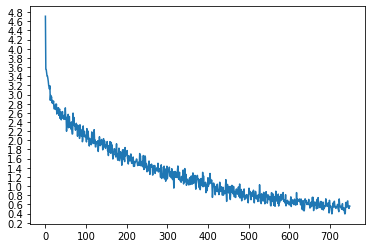

In [41]:
trainAttnIters(encoder2, decoder2, 75000, print_every=5000)

In [44]:
def evaluateAttn(encoder, decoder, sentence, max_lenght=MAX_LEN):
  input_variable = variableFromSentence(input_lang, sentence)
  input_length = input_variable.size()[0]
  encoder_hidden = encoder.initHidden()

  encoder_outputs = Variable(torch.zeros(max_lenght, encoder.hidden_size))
  encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs

  for encoder_index in range(input_length):
    encoder_output, encoder_hidden = encoder(input_variable[encoder_index], encoder_hidden)
    encoder_outputs[encoder_index] = encoder_outputs[encoder_index] + encoder_output[0][0]

  decoder_input = Variable(torch.LongTensor([[SOS_token]])) #RNN -> 2dim
  decoder_input = decoder_input.cuda() if use_cuda else decoder_input
  decoder_hidden = encoder_hidden

  decoded_words = []
  decoder_attetions = torch.zeros(max_lenght, max_lenght) #存每次的關注點
  for decoder_index in range(max_lenght):
    decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
    decoder_attetions[decoder_index] = decoder_attention.data
    topv, topidx = decoder_output.data.topk(1)
    ni = topidx[0][0] #type:tensor
    
    if ni == EOS_token:
      decoded_words.append('<EOS>')
      break
    else:
      decoded_words.append(output_lang.index2word[ni.item()]) 

    decoder_input = Variable(torch.LongTensor([[ni]])) #RNN -> 2dim
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input
  
  return decoded_words, decoder_attetions[:decoder_index+1]

In [90]:
# def show_attention(input_sentence, output_words, attention_matrix):
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     cax = plt.matshow(attention_matrix.numpy(), cmap='bone')
#     fig.colorbar(cax)
#     ax.set_xticklabels(['']+input_sentence.split(' ')+ ['<EOS>'], rotation=90)
#     ax.set_yticklabels(['']+output_words)
#     ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
#     ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

#     fig.tight_layout()
#     plt.show()

In [91]:
def show_attention(input_sentence, output_words, attention_matrix):
    figure = plt.figure()
    axes = figure.add_subplot(111)
      
    # using the matshow() function 
    caxes = axes.matshow(attention_matrix, interpolation ='nearest')
    figure.colorbar(caxes)
      
    axes.set_xticklabels(['']+input_sentence.split(' ')+ ['<EOS>'])
    axes.set_yticklabels(['']+output_words)
      
    plt.show()

In [92]:
def evaluateAttnRandom(encoder, decoder, num=10):
  for i in range(num):
    pair = random.choice(pairs)
    print('>', pair[0])
    print('=', pair[1])
    output_words, attetions = evaluateAttn(encoder, decoder, pair[0], max_lenght=MAX_LEN)
    output_sentence = ' '.join(output_words)
    print('<', output_sentence)
    print()
    show_attention(pair[0], output_words, attetions)

> ils viennent pour moi .
= they re coming for me .
< they re coming for me . <EOS>



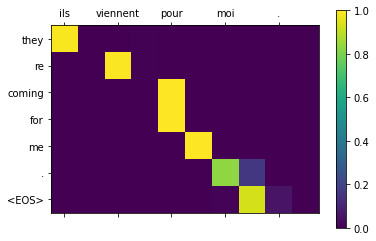

> j ai l habitude de me lever tot .
= i m used to getting up early .
< i m getting up early . <EOS>



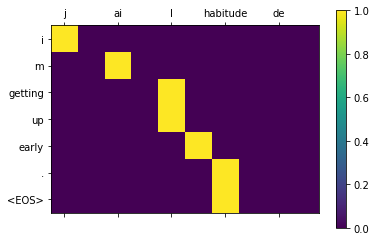

> je ne suis pas aussi occupe que tom .
= i m not as busy as tom .
< i m not as busy as tom . <EOS>



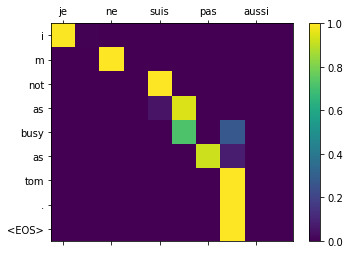

> je n ai plus peur de vous .
= i m not scared of you anymore .
< i m not scared of you anymore . <EOS>



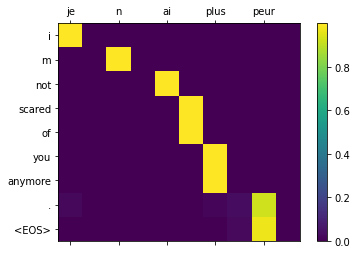

> je ne suis vraiment pas occupee .
= i m really not busy .
< i m really not busy . <EOS>



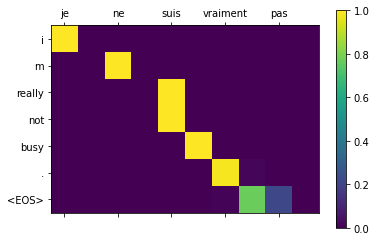

> je suis farouchement oppose a un compromis .
= i m strongly opposed to a compromise .
< i m willing to see a food . <EOS>



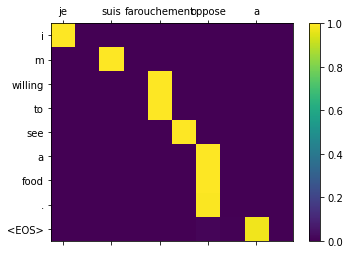

> ils sont en train de mourir .
= they re dying .
< they re dying . <EOS>



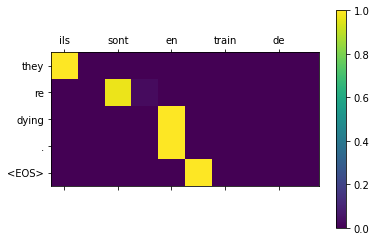

> il est borne .
= he is thick headed .
< he is thick headed . <EOS>



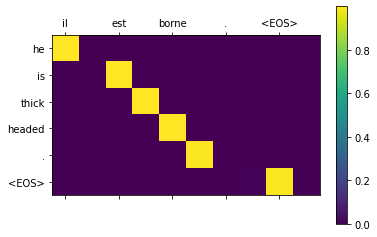

> tu es sournois .
= you re sneaky .
< you re sneaky . <EOS>



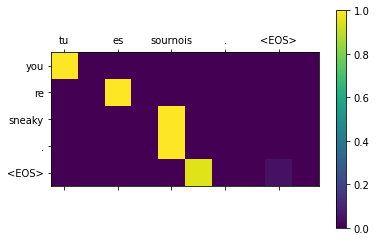

> tu es grossiere .
= you re rude .
< you re rude . <EOS>



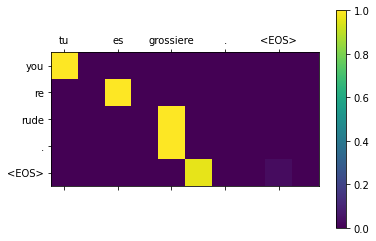

In [93]:
evaluateAttnRandom(encoder2, decoder2, num=10)